# Analyse Research Open Data with ROOT's RDataFrame

This note book will show you how to build up an analysis on the Research Open Data using ROOT's RDataFrame. RDataFrame offers a modern, high-level interface for analysis of data stored in TTree, CSV and other data formats, in C++ or Python.

In addition, multi-threading and other low-level optimisations allow users to exploit all the resources available on their machines completely transparently.

RDataFrame allows you to interact with the Reserach Open Data in a "columnar style" way. Calculations are expressed in terms of actions and transformations, RDataFrame takes care of their execution. The implementation automatically puts in place several low level optimisations such as multi-thread parallelization and caching.

Let's start by getting ROOT installed in your environment. The exact procedure will depend on where you run your framework. If you use Google Colab or Swan you should set the appropriate variable to True below and ROOT will be setup correctly.

If you're working on your own machine is relatively simple to install ROOT, please look at the [documentation pages](https://root.cern.ch/install/).

There's lot's of useful documentation on RDataFrames [here](https://root.cern/doc/master/classROOT_1_1RDataFrame.html).

In [ ]:
isSwan = False
isColab = True
isBinder = False
isGalaxy = False

Continue to the setup. This may take some time depending on your internet connection, as a few files will need to be downloaded.

In [ ]:
import os
if isColab:
    if not os.path.exists("/content/root_build"):
        if not os.path.exists("/content/root_v6.32.04_Ubuntu_Python3.12.zip"):
            !wget -q --show-progress https://github.com/MohamedElashri/ROOT/releases/download/root-v6.32.04-python3.12/root_v6.32.04_Ubuntu_Python3.12.zip
        !unzip -q /content/root_v6.32.04_Ubuntu_Python3.12.zip
    !wget http://archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2_amd64.deb
    !sudo dpkg -i libssl1.1_1.1.1f-1ubuntu2_amd64.deb
    !rm -f libssl1.1_1.1.1f-1ubuntu2_amd64.deb
    !sudo apt install xrootd-client xrootd-server python3-xrootd
    import sys
    import ctypes

    # Step 1: Append ROOT paths to Python
    sys.path.append("root_build/")
    sys.path.append("root_build/bin/")
    sys.path.append("root_build/include/")
    sys.path.append("root_build/lib/")

    # Step 2: Load the required shared libraries (.so files)
    ctypes.cdll.LoadLibrary("root_build/lib/libCore.so")
    ctypes.cdll.LoadLibrary("root_build/lib/libThread.so")
    ctypes.cdll.LoadLibrary("root_build/lib/libTreePlayer.so")

    print("ROOT Libraries Loaded Successfully!")
elif isSwan:
    print("INFO \t Nothing to be done. ROOT's already installed!")
elif isBinder:
    print("ERROR \t Running the notebook in Binder is not yet supported")
else:
    print("ERROR \t Please specify your environment (Swan or Google Colab) or create your own setup...")

In [ ]:
import ROOT
print(f"ROOT Version: {ROOT.gROOT.GetVersion()}")

In [ ]:
# Tip: If you'd like to mount your drive in google (e.g. to store the root distribution for next time)
# you can do so here. This would mean that you don't have to download the root distribution
# file every time, but you can rather get it from your google drive (which is not deleted after some certain amount of time.)
# Load the Drive helper and mount
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# First we install atlasopenmagic into our SWAN environment
# Notice that we need --user to avoid trying to install the package in a
# read-only file system This is a problem unique to SWAN; on binder or colab you
# won't need --user, but it doesn't hurt
%pip install --user atlasopenmagic

In [ ]:

# Now we have to do a little bit of work to make sure that atlasopenmagic is
# available in our python path This is because SWAN by default does not include
# the local package installation area in the PYTHONPATH Again, this is not
# necessary on binder or colab - there you can remove these lines if you like,
# though they don't do any harm
import sys
import os
import re
import json
sys.path += [ f'{os.environ["HOME"]}/.local/lib/python{sys.version_info.major}.{sys.version_info.minor}/site-packages' ]

import atlasopenmagic as atom

## Simple Introduction

We will start by loading one file from the Research Open Data release. You specify the name of the TTree (`CollectionTree` for all files in the OD for research release) and the filename.

This will throw a bunch of Wanring messages as there are several of the branches we can not read in the PHYSLITE files (need ATLAS software). But we can ignore this for now as we are not gonna use any of those branches.

In [ ]:
# Large file: root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37110937._000011.pool.root.1
# Small file: root://eospublic.cern.ch:1094//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000001.pool.root.1
df = ROOT.RDataFrame("CollectionTree","root://eospublic.cern.ch:1094//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000001.pool.root.1")

In [ ]:
df = df.Define("photon_isTightID","AnalysisPhotonsAuxDyn.DFCommonPhotonsIsEMTight")
df = df.Filter('ROOT::VecOps::Sum(photon_isTightID)>=2',"Two tight photons")
df = df.Define("photon_pt","AnalysisPhotonsAuxDyn.pt/1000.")
df = df.Filter("Sum(photon_pt>50)>0 && Sum(photon_pt>30)>1","Pt > 50, 30 GeV")

In [ ]:
df.Report().Print()

In [ ]:
df = df.Define("photon_pt[photon_isTightID]","AnalysisPhotonsAuxDyn.pt/1000.")
histogram = df.Histo1D(("h_pt","Invariant mass of two photons;m_{ee} [GeV];Events",100,0,200),"photon_pt")

In [ ]:
c = ROOT.TCanvas()
c.Draw()
histogram.Draw()

Most actions in RDataFrame are **lazy**, i.e. they are not executed on the spot, but registered with RDataFrame and executed only when a result is accessed for the first time.

One example of a lazy action is the Count() function, returning the number of events loaded in our RDF. This means that the following command does nothing (except for making a pointer object to the results):

In [ ]:
ptr = df.Count()

When we explicitely ask to get the number of events the execution is launched

In [ ]:
ptr.GetValue()

We can also look at the content of the TTree in RDF. This function does not modify the dataframe or book computations, but simply return information on the RDataFrame object.

Note that the only branches we can actually read in RDF are the ones with `AuxDyn` in the name so let's just print those.

If you're not familiar with the content of the PHYSLITE files you should consider looking through the following notebook: [Using the PHYSLITE format](https://opendata.atlas.cern/docs/tutresearch/physlitetut)

In [ ]:
# Get list of readable branches
# The list auxDyn will contain all the name and data type of all readable branches
auxDyn = []
for name in df.GetColumnNames():
  if "AuxDyn" in str(name):
    print(name)

## A first simple analysis

Let's start with defining some new variables, make some selections and make a histogram.

We start by defining "good" electrons with some basic $p_T$, $\eta$ and quality requirements.

In [ ]:
# Use Define to create new variables from existing ones
df = df.Define("signal_el","AnalysisElectronsAuxDyn.eta > -2.47 && \
                            AnalysisElectronsAuxDyn.eta <  2.47 && \
                            AnalysisElectronsAuxDyn.pt > 7000 && \
                            AnalysisElectronsAuxDyn.DFCommonElectronsLHTight")

In [ ]:
# Count the number of good electrons in each event
df = df.Define('n_signal_el','ROOT::VecOps::Sum(signal_el)')

In [ ]:
# Requre at least two good electrons in every event
df = df.Filter('n_signal_el >= 2',"At least two good electrons")

RDataFrame comes with a function to present an overview of the number of events passing each selection crieria (specified by the Filter()-command). Above we only added one selection, but let's see how many events passed the selection.

Report() is also lazy so nothing gets executed if you don't call Print().

In [ ]:
df.Report().Print()

### Using C++ function in RDataFrame

One thing which is very useful in RDF and ROOT is to use C++ functions from python. In Colab we need to make sure the PATH's are set so that the system finds the ROOT Cling compiler.  

In [ ]:
os.environ['ROOTSYS'] = '/content/root_build'
os.environ['PATH'] += ':/content/root_build/bin'
os.environ['LD_LIBRARY_PATH'] += ':/content/root_build/lib'

Then we can define a C++ function within the `ROOT.gInterpreter.Declare` and it will be compile immediately. It can take as input any of the variables available in our dataframe.


In [ ]:
# Define the function to calculate invariant mass of 2 and 4 leptons
ROOT.gInterpreter.Declare(
    """
#include <TMath.h>
using VecF_t = const ROOT::RVec<float>&;
float ComputeInvariantMass(VecF_t& pt, VecF_t& eta, VecF_t& phi)
{
  if(int(pt.size())<2)return -999;
  ROOT::Math::PtEtaPhiMVector p1(pt[0], eta[0], phi[0], 0.511);
  ROOT::Math::PtEtaPhiMVector p2(pt[1], eta[1], phi[1], 0.511);
  return (p1 + p2).M()/1000.;
};

float ComputeInvariantMass4E(VecF_t& pt, VecF_t& eta, VecF_t& phi)
{
  if(int(pt.size())<4)return -999;
  ROOT::Math::PtEtaPhiMVector p1(pt[0], eta[0], phi[0], 0.511);
  ROOT::Math::PtEtaPhiMVector p2(pt[1], eta[1], phi[1], 0.511);
  ROOT::Math::PtEtaPhiMVector p3(pt[2], eta[2], phi[2], 0.511);
  ROOT::Math::PtEtaPhiMVector p4(pt[3], eta[3], phi[3], 0.511);
  return (p1 + p2 + p3 + p4).M()/1000.;
};
"""
)

We can now call on the C++ function in Python to create a new variable.

In [ ]:
df = df.Define('mee','ComputeInvariantMass(AnalysisElectronsAuxDyn.pt[signal_el],\
                                           AnalysisElectronsAuxDyn.eta[signal_el],\
                                           AnalysisElectronsAuxDyn.phi[signal_el])')

In [ ]:
# We can display the first 5 entries of the newly
# created variable mee (again, it is lazy so Print()
# is needed).
df.Display(["mee"]).Print()

RDF comes with functions to define histograms (see [TH1 documentation](https://root.cern.ch/doc/v636/classTH1.html)). Let's create a histogram with the invariant mass of the two electrons.

In [ ]:
# lazy, nothing is done until we use the histogram
histogram = df.Histo1D(("h_mee","Invariant mass of two electrons;m_{ee} [GeV];Events",100,0,200),"mee")

In [ ]:
%jsroot on
c = ROOT.TCanvas("c","c",1)
c.Draw()
# This would trigger the execution
histogram.Draw()

## A more complete analysis in RDF

Let's move to a slightly more complete analysis using RDataFrame and Research Open Data. To get hold of the data and corresponding metadata we will use `atlasopenmagic`.

In [ ]:
atom.available_releases()
# Set the release to the Research Open Data release
# If access to /eos/ (e.g. in some instances of Swan) 
# files can be accessed directly from there. If not we need
# to use https/root protocol and cache them (see next cell)
if os.path.exists("/eos/opendata"):
    atom.set_release('2024r-pp',local_path="eos")
else:
    atom.set_release('2024r-pp')

In [ ]:
# Define the input data sets we'd like to use (a selection of samples used for the H->ZZ analysis)
# Unfortunately Google Colab is too slow so in interest of time let's only look at one smaller Higgs sample
if isColab:
    defs = {
        'Higgs':  {'dids': [345060],'color': "#00cdff" },# light blue
    }
else:
    defs = {
        'Zjets' :{'dids': [700320,700321,700322], 'color': "#6b59d3" },
        'ZZ':     {'dids': [700600],'color': "#ff0000" },# red
        'Higgs':  {'dids': [345060, 346228, 346310],'color': "#00cdff" },# light blue
        'Data':{'dids':['data']}
    }

# In swan we can access the samples directly from /eos/ while in colab we must use the root (or https) protocols
samples   = atom.build_dataset(defs, protocol='root' if isColab else 'eos', cache=True)

When we later are gonna parallelize our execution it is beneficial to put all the files we want to process into one big RDataFrame

Remember that we will not have any memory issues doing this since ROOT is handling memory in a completely different way than e.g. is done in Pandas dataframe

However, we still need to know which process (real data, simulated ttbar, simulated diboson etc.) each file belongs to when we later want to plot histograms etc. We achieve this by loading the RDataFrame using a specification file in json format (see [documentation](https://root.cern/doc/v632/classROOT_1_1RDataFrame.html)).

We would also need to store some of the metadata used to scale the simulations to data.

We start by creating the json file.


In [ ]:
# Name of the json file.
outfilename = "./spec.json"
# Outermost key must be "samples"
RDF_spec = {"samples":{}}
# loping over the samples defined above
for name, info in defs.items():
    for did in info["dids"]:
        if not "Data" in name:
            # Get the metadata from atom
            metadata = {'xsec':atom.get_metadata(did,'cross_section_pb'),
                    'sumOfWeights':atom.get_metadata(did,'sumOfWeights'),
                    'genFiltEff':atom.get_metadata(did,'genFiltEff'),
                    'kFactor':atom.get_metadata(did,'kFactor'),
                    'proc':name}
            # Populates the dictionary with input samples and metadata
            RDF_spec['samples'][did] = {"trees":["CollectionTree"],
                                        "files":[item.replace("simplecache::", "") for item in atom.get_urls(str(did), protocol='root', cache=True)],
                                        "metadata":metadata}
        else:
            # In interest of time we only look at one run in data (i.e. onlt files with id 37020379 in name)
            inputlist = [item.replace("simplecache::", "") for item in atom.get_urls(str(did), protocol='root', cache=True) if '37020379' in item]
            # metadata is simple for data
            metadata = {'xsec':1.0,
                    'sumOfWeights':1.0,
                    'genFiltEff':1.0,
                    'kFactor':1.0,
                    'proc':name}
            # Populates the dictionary with input samples and metadata
            RDF_spec['samples'][did] = {"trees":["CollectionTree"], "files":inputlist, "metadata":metadata}
# Save the dictionary to json file
with open(outfilename, "w") as f:
    json.dump(RDF_spec,f)
print("Created json file %s\nCan now be loaded into a RDataFrame using:\ndf = ROOT.RDF.Experimental.FromSpec(\"spec.json\")"%outfilename)

In [ ]:
! lscpu | grep 'CPU(s):'

In [ ]:
ROOT.EnableImplicitMT()

In [ ]:
df = ROOT.RDF.Experimental.FromSpec("spec.json")

In [ ]:
# Get category
df = df.DefinePerSample("isData",f'rdfsampleinfo_.Contains("mc20_13TeV") ? 0 : 1')

In [ ]:
# Get category
df = df.DefinePerSample("category",'rdfsampleinfo_.GetS("proc")')
# Get cross-section
df = df.DefinePerSample("xsec",'rdfsampleinfo_.GetD("xsec")')
# Get sum of event weights
df = df.DefinePerSample("sow",'rdfsampleinfo_.GetD("sumOfWeights")')
# Get generator filter efficiency
df = df.DefinePerSample("eff",'rdfsampleinfo_.GetD("genFiltEff")')
# Get k-factor
df = df.DefinePerSample("kfac",'rdfsampleinfo_.GetD("kFactor")')
# Set the luminoisty of the data set (run 311481) you've added (36.1e3 if you have loaded everything)
df = df.DefinePerSample("lumi",'343.1')

In [ ]:
# Calculate the weight to be applied to every event (for data it is simply 1)
wgtstr = f'isData ? 1.0 : ((lumi*xsec*kfac*eff)/sow)*EventInfoAuxDyn.mcEventWeights.at(0)'
df = df.Define("wgt",wgtstr)

In [ ]:
# Define signal electrons
df = df.Define("signal_el","AnalysisElectronsAuxDyn.eta > -2.47 && \
                            AnalysisElectronsAuxDyn.eta <  2.47 && \
                            AnalysisElectronsAuxDyn.pt > 7000 && \
                            AnalysisElectronsAuxDyn.DFCommonElectronsLHLoose")
# Make a new variable with the number of signal electrons per event
df = df.Define('n_signal_el','ROOT::VecOps::Sum(signal_el)')
# Only select events with at leas four signal electrons
df = df.Filter('n_signal_el >= 4',"At least four electrons passing cuts")
# Calculate the invariant mass of those four electrons
df = df.Define('m4e','ComputeInvariantMass4E(AnalysisElectronsAuxDyn.pt[signal_el],\
                                           AnalysisElectronsAuxDyn.eta[signal_el],\
                                           AnalysisElectronsAuxDyn.phi[signal_el])')

In [ ]:
all_histograms = []
histograms = {}
for proc in defs.keys():
  histograms[proc] = df.Filter(f'category == "{proc}"').Histo1D(("h_m4e_%s"%proc,"Invariant mass of 4 electrons;m_{4e} [GeV];Events",50,0,1000),"m4e","wgt")
  all_histograms.append(histograms[proc])

In [ ]:
ROOT.RDF.RunGraphs(all_histograms)

In [ ]:
hstack = ROOT.THStack()
legend = ROOT.TLegend(0.6,0.7,0.9,0.9)
for proc in defs.keys():
    print("Integral %s : %f"%(proc,histograms[proc].Integral(0,histograms[proc].GetNbinsX()+1)))
    if not "Data" in proc:
        histograms[proc].SetLineColor(ROOT.TColor.GetColor(defs[proc]['color']))
        histograms[proc].SetFillColor(ROOT.TColor.GetColor(defs[proc]['color']))
        hstack.Add(histograms[proc].GetValue())
        legend.AddEntry(histograms[proc].GetValue(),proc,"lf")
    else:
        histograms[proc].SetMarkerColor(ROOT.kBlack)
        histograms[proc].SetLineColor(ROOT.kBlack)
        histograms[proc].SetMarkerStyle(20)
        legend.AddEntry(histograms[proc].GetValue(),proc,"p")

In [ ]:
#%jsroot on
c = ROOT.TCanvas("c","c",1)
c.Draw()
hstack.Draw("hist")
hstack.GetXaxis().SetTitle("m_{4e} [GeV]")
hstack.GetYaxis().SetTitle("Entries")
hstack.SetMaximum(25)
if "Data" in histograms.keys():
    histograms["Data"].Draw("ep same")
legend.Draw()

## Convert from ROOT to NumPy

You can easilly convert your RDataFrame into NumPy arrays and Pandas data frames.

Let's first define some simple variables.

In [ ]:
df = df.Define("lep1_pt","AnalysisElectronsAuxDyn.pt[signal_el].at(0)")
df = df.Define("lep2_pt","AnalysisElectronsAuxDyn.pt[signal_el].at(1)")
df = df.Define("lep3_pt","AnalysisElectronsAuxDyn.pt[signal_el].at(2)")
df = df.Define("lep4_pt","AnalysisElectronsAuxDyn.pt[signal_el].at(3)")
df = df.Define("label",f'category == "Higgs" ? 1 : 0')

Specify the columns we'd like to convert to numpy arrays (and put into Pandas data frame)

In [ ]:
numpy_col = ["lep1_pt","lep2_pt","lep3_pt","lep4_pt","m4e","label","isData","wgt","category"]

Import `pandas` and make the conversion from ROOT to Pandas (**not lazy**)

In [ ]:
import pandas as pd
pandas_df = pd.DataFrame(data=df.AsNumpy(numpy_col))

Look at the content

In [ ]:
pandas_df.head()

## Machine Learning with RDataFrame

It is possible to use the RDataFrames directly in creating PyTorch tensors for machine learning. You already went through a nice tutorial on doing this (if you didn't you should consider doing it). In the following we will do a similar ML tutorial, but instead of using Uproot and awkward arrays we will use directly the RDataFrames and Research Open Data.

Not that to be able to do this you need a relatively recent version of ROOT (>= 6.38) and thus it will not work (properly) in Google Colab (root 6.32)

In case you haven't run the complete notebook we setup a few things again.

In [1]:
import ROOT
print(f"ROOT Version: {ROOT.gROOT.GetVersion()}")

ROOT Version: 6.39.01


In [2]:
# First we install atlasopenmagic into our SWAN environment
# Notice that we need --user to avoid trying to install the package in a
# read-only file system This is a problem unique to SWAN; on binder or colab you
# won't need --user, but it doesn't hurt
%pip install --user atlasopenmagic

  Using cached atlasopenmagic-1.8.0-py3-none-any.whl.metadata (5.8 kB)
Using cached atlasopenmagic-1.8.0-py3-none-any.whl (21 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Now we have to do a little bit of work to make sure that atlasopenmagic is
# available in our python path This is because SWAN by default does not include
# the local package installation area in the PYTHONPATH Again, this is not
# necessary on binder or colab - there you can remove these lines if you like,
# though they don't do any harm
import sys
import os
import re
import json
sys.path += [ f'{os.environ["HOME"]}/.local/lib/python{sys.version_info.major}.{sys.version_info.minor}/site-packages' ]

import atlasopenmagic as atom

In [4]:
if os.path.exists("/eos/opendata"):
    atom.set_release('2024r-pp',local_path="eos")
else:
    atom.set_release('2024r-pp')

Fetching metadata for release: 2024r-pp...
Fetching datasets: 100%|██████████| 374/374 [00:00<00:00, 1152.29datasets/s]
✓ Successfully cached 374 datasets.
Active release: 2024r-pp. (Datasets path: eos)


As is done in the ML tutorial on Education and outreach Open Data we'd like to build a supervised classifier that separates fully leptonic $t\bar{t}$ ($t \to bW$, $\bar{t} \to \bar{b}W$ (both $W \to ℓ\nu$) from Higgs boson events, where $H \to WW$ and both $W \to ℓν$. Let's start loading the DSIDs with the simulations of these two processes.

In [5]:
MLdefs = {
        'ttbar' :{'dids': [411234], 'color': "#6b59d3" },
        'ggHWW'   :{'dids': [346802],'color': "#ff0000" }
        }
#In swan we can access the samples directly from /eos/ while in colab we must use the root (or https) protocols
samples   = atom.build_dataset(MLdefs, cache=True)

Make the json file which will be used to define the RDataFrame (as explained earlier)

In [6]:
# Name of the json file.
outfilename = "./MLspec.json"
# Outermost key must be "samples"
RDF_spec = {"samples":{}}
# loping over the samples defined above
for name, info in MLdefs.items():
    for did in info["dids"]:
        # Get the metadata from atom
        metadata = {'xsec':atom.get_metadata(did,'cross_section_pb'),
                    'sumOfWeights':atom.get_metadata(did,'sumOfWeights'),
                    'genFiltEff':atom.get_metadata(did,'genFiltEff'),
                    'kFactor':atom.get_metadata(did,'kFactor'),
                    'proc':name}
        # Populates the dictionary with input samples and metadata 
        RDF_spec['samples'][did] = {"trees":["CollectionTree"],
                                    "files":[item for item in atom.get_urls(str(did), protocol='root', cache=True)[-1:]],
                                    "metadata":metadata}
# Save the dictionary to json file
with open(outfilename, "w") as f:
    json.dump(RDF_spec,f)
print("Created json file %s\nCan now be loaded into a RDataFrame using:\ndf = ROOT.RDF.Experimental.FromSpec(\"%s\")"%(outfilename,outfilename))

Created json file ./MLspec.json
Can now be loaded into a RDataFrame using:
df = ROOT.RDF.Experimental.FromSpec("./MLspec.json")


We need another C++ function which can take the input from the two containers containing electrons and muons and merge them into one common *lepton* vector. In case you haven't set the paths to the ROOT C++ compiler we do that again (doesn't hurt to do it twice) 

In [7]:
os.environ['ROOTSYS'] = '/content/root_build'
os.environ['PATH'] += ':/content/root_build/bin'
os.environ['LD_LIBRARY_PATH'] += ':/content/root_build/lib'

In [8]:
# Takes as input two vectors and merges the them into a common vector 
# Returns the joint vector.
ROOT.gInterpreter.Declare(
    """
    using VecF_t = const ROOT::RVec<float>&;
    ROOT::RVec<float> getVector(VecF_t& inp1, VecF_t& inp2, Float_t m1 = 0 , Float_t m2 = 0){
      ROOT::RVec<float> ret_vec;
      const auto ninp1 = int(inp1.size());
      for (int j=0; j < ninp1; ++j) {
        if(m1)ret_vec.push_back(fabs(inp1.at(j))*m1);
        else ret_vec.push_back(inp1.at(j));
      }
  
      const auto ninp2 = int(inp2.size());
      for (int j=0; j < ninp2; ++j) {
        if(m2)ret_vec.push_back(fabs(inp2.at(j))*m2);
        else ret_vec.push_back(inp2.at(j));
      }
  return ret_vec;
}
"""
)

True

We also need a function to normalize the features we will use in the network. The following takes the mean and standard deviation of each feature and performs standard scaling. It returns the dataframe with the original features replaced by the scaled features.

In [9]:
def NormalizeColumns(df, columns, means, stddevs):
    for col in columns:
        mean = means[col]
        std = stddevs[col]
        if std == 0:
            raise ValueError(f"Standard deviation of column '{col}' is zero. Cannot normalize.")
        
        df = df.Redefine(col, f"({col} - {mean}) / {std}")
        print(f"[INFO] Normalized column: {col} ")
    return df

In [10]:
# Define the RDataFrame and use multi threading
#ROOT.EnableImplicitMT(4)
df = ROOT.RDF.Experimental.FromSpec("MLspec.json");

Warning in <TClass::Init>: no dictionary for class DataHeader_p6 is available
Warning in <TClass::Init>: no dictionary for class DataHeaderForm_p6 is available
Warning in <TClass::Init>: no dictionary for class xAOD::AuxContainerBase is available
Warning in <TClass::Init>: no dictionary for class ElementLinkBase is available
Warning in <TClass::Init>: no dictionary for class xAOD::AuxInfoBase is available
Warning in <TClass::Init>: no dictionary for class xAOD::EventInfo_v1 is available
Warning in <TClass::Init>: no dictionary for class xAOD::TrigConfKeys_v1 is available
Warning in <TClass::Init>: no dictionary for class xAOD::TrigDecisionAuxInfo_v1 is available
Warning in <TClass::Init>: no dictionary for class xAOD::TrigDecision_v1 is available
Warning in <TClass::Init>: no dictionary for class xAOD::EventShape_v1 is available
Warning in <TClass::Init>: no dictionary for class ElementLink<DataVector<xAOD::Vertex_v1> > is available
Warning in <TClass::Init>: no dictionary for class Ev

In [11]:
#for col in df.GetColumnNames():
#    if "AuxDyn" in col:
#        print(col)

### Preparing the data set for ML

In the next few cells we will prepare the data set to be given to the ML algorithm in PyTorch. We will use basic information about electrons, muons, jets and missing transverse energy as input features. Furthermore, to avoid having varying sized vectors we will convert them into flat variables (e.g. in stead of **lep_pt** we will provide the network with **lep1_pt**, **lep2_pt** for each lepton **1**, **2** etc.). 

In [12]:
# Find which samples the events are from (ttbar or ggHWW)
df = df.DefinePerSample("category",'rdfsampleinfo_.GetS("proc")')

In [13]:
# Define signal objects
df = df.Define("signal_el","AnalysisElectronsAuxDyn.eta > -2.47 && \
                            AnalysisElectronsAuxDyn.eta <  2.47 && \
                            AnalysisElectronsAuxDyn.pt > 10000 && \
                            AnalysisElectronsAuxDyn.DFCommonElectronsLHLoose")
df = df.Define("signal_mu","AnalysisMuonsAuxDyn.eta > -2.47 && \
                            AnalysisMuonsAuxDyn.eta <  2.47 && \
                            AnalysisMuonsAuxDyn.pt > 10000")
df = df.Define("signal_jet","AnalysisJetsAuxDyn.eta > -2.5 && \
                            AnalysisJetsAuxDyn.eta <  2.5 && \
                            AnalysisJetsAuxDyn.pt > 20000 && \
                            AnalysisJetsAuxDyn.NNJvtPass")
# This will be our target vector, 1 if events are from ggHWW, 0 otherwise
df = df.Define("isSignal",f'category == "ggHWW" ? 1 : 0')

In [14]:
# Some object multiplicities
df = df.Define("n_jet", "ROOT::VecOps::Sum(signal_jet)")
df = df.Define("n_el", "ROOT::VecOps::Sum(signal_el)")
df = df.Define("n_mu", "ROOT::VecOps::Sum(signal_mu)")
df = df.Define("n_lep","n_el + n_mu")
# MET variables
df = df.Define("met_et","MET_TruthAuxDyn.sumet.at(0)/1000.")
df = df.Define("met_phi","atan(MET_TruthAuxDyn.mpy.at(0)/MET_TruthAuxDyn.mpx.at(0))")

In [15]:
# Some selections (2 jets and at least two leptons (electrons/muons))
df = df.Filter("n_jet == 2","Exactly two jets")
df = df.Filter("n_lep >= 2","At least two leptons")

In [16]:
# Here we define the lepton vectors which merges the two sepearete collections of electrons and muons into one
# The getVector-function was defined above. 
df = df.Define('lep_pt',"getVector(AnalysisElectronsAuxDyn.pt[signal_el],AnalysisMuonsAuxDyn.pt[signal_mu])")
df = df.Define('lep_eta',"getVector(AnalysisElectronsAuxDyn.eta[signal_el],AnalysisMuonsAuxDyn.eta[signal_mu])")
df = df.Define('lep_phi',"getVector(AnalysisElectronsAuxDyn.phi[signal_el],AnalysisMuonsAuxDyn.phi[signal_mu])")
# Returns the charge*mass (me = 0.511 MeV, mmu = 105.66 MeV)
df = df.Define('lep_mass',"getVector(AnalysisElectronsAuxDyn.charge[signal_el],AnalysisMuonsAuxDyn.charge[signal_mu],0.511,105.66)")
df = df.Define('lep_charge',"getVector(AnalysisElectronsAuxDyn.charge[signal_el],AnalysisMuonsAuxDyn.charge[signal_mu])")

In [17]:
# Start adding the features we'd like to give to the NN
mycolumns = ['met_et','n_el','n_mu','n_lep']#,'met_phi'
# Makes flat variables for the first two leptons and jets.
# Will always be at least 2 of these since we did the selections above
for i in range(1,3):
    df = df.Define("jet%i_pt"%i, "AnalysisJetsAuxDyn.pt[signal_jet].at(%i)/1000."%(i-1))
    df = df.Define("lep%i_pt"%i, "lep_pt.at(%i)/1000."%(i-1))
    
    df = df.Define("jet%i_eta"%i, "AnalysisJetsAuxDyn.eta[signal_jet].at(%i)"%(i-1))
    df = df.Define("lep%i_eta"%i, "lep_eta.at(%i)"%(i-1))
    
    df = df.Define("jet%i_phi"%i, "AnalysisJetsAuxDyn.phi[signal_jet].at(%i)"%(i-1))
    df = df.Define("lep%i_phi"%i, "lep_phi.at(%i)"%(i-1))
    
    df = df.Define("jet%i_mass"%i, "AnalysisJetsAuxDyn.m[signal_jet].at(%i)/1000."%(i-1))
    df = df.Define("lep%i_mass"%i, "lep_mass.at(%i)/1000."%(i-1))
    
    df = df.Define("lep%i_charge"%i, "lep_charge.at(%i)"%(i-1))
    
    ## And add them to the features
    mycolumns.append("jet%i_pt"%i)
    mycolumns.append("lep%i_pt"%i)
    
    mycolumns.append("jet%i_eta"%i)
    mycolumns.append("lep%i_eta"%i)
    
    mycolumns.append("jet%i_phi"%i)
    mycolumns.append("lep%i_phi"%i)
    
    mycolumns.append("jet%i_mass"%i)
    mycolumns.append("lep%i_mass"%i)
    
    mycolumns.append("lep%i_charge"%i)

Now we turn to the standard scaling of our input features. For every feature we store the mean and standard deviation. This is then used to perform the scaling (in NormalizeColumns).

In [18]:
mean = {col: df.Mean(col) for col in mycolumns}
stddev = {col: df.StdDev(col) for col in mycolumns}
    
ROOT.RDF.RunGraphs(list(mean.values()) + list(stddev.values()))

mean_val = {col: mean[col].GetValue() for col in mycolumns}
stddev_val = {col: stddev[col].GetValue() for col in mycolumns}

for col, val in mean_val.items():
    print(f"[INFO] Mean of data {col}: {val}")

for col, val in stddev_val.items():
    print(f"[INFO] Stddev of data {col}: {val}")
    

df = NormalizeColumns(df, mycolumns, mean_val, stddev_val)

[INFO] Mean of data met_et: 64.98008803477113
[INFO] Mean of data n_el: 1.0385713153096012
[INFO] Mean of data n_mu: 0.979703480535955
[INFO] Mean of data n_lep: 2.018274795845556
[INFO] Mean of data jet1_pt: 56.163044615349115
[INFO] Mean of data lep1_pt: 34.34036220101532
[INFO] Mean of data jet1_eta: 0.00026733849270640665
[INFO] Mean of data lep1_eta: -0.004583949190504022
[INFO] Mean of data jet1_phi: 0.023679531517266438
[INFO] Mean of data lep1_phi: -0.00327228484220114
[INFO] Mean of data jet1_mass: 6.634952459601749
[INFO] Mean of data lep1_mass: 0.023678294137525473
[INFO] Mean of data lep1_charge: 0.002457781653849203
[INFO] Mean of data jet2_pt: 32.52580159065175
[INFO] Mean of data lep2_pt: 29.164770692703588
[INFO] Mean of data jet2_eta: -0.007599908017821914
[INFO] Mean of data lep2_eta: 0.0035200617509335984
[INFO] Mean of data jet2_phi: 0.029032605921021994
[INFO] Mean of data lep2_phi: -0.005168781019176718
[INFO] Mean of data jet2_mass: 4.540291358070039
[INFO] Mean 

In [19]:
# After scaling we add the target vector
target = "isSignal"  
mycolumns.append("isSignal")

In [21]:
df.Snapshot("analysis","./MLtrain.root",mycolumns)

<cppyy.gbl.ROOT.RDF.RResultPtr<ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> > object at 0x23f10870>

In [22]:
df = ROOT.RDataFrame("analysis","./MLtrain.root")

In [23]:
# Get the number of events in data set
dataset_size = df.Count().GetValue()
print("Number of events : %i"%dataset_size)

Number of events : 25226


In [46]:
num_epochs = 3
number_of_chunks = 1
blocks_per_chunk = 2

shuffle = True
set_seed = 42
batch_size = 1000
chunk_size = int(dataset_size / number_of_chunks)
block_size = int(chunk_size / blocks_per_chunk)

In [47]:
# Getting training and validaion sets (as pytorch tensors)
gen_train, gen_validation =  ROOT.TMVA.Experimental.CreatePyTorchGenerators(df,
                                                                            batch_size,
                                                                            chunk_size,
                                                                            block_size,
                                                                            shuffle = True,
                                                                            columns = mycolumns,
                                                                            target = target,
                                                                            drop_remainder = True,
                                                                            set_seed = 42,
                                                                            validation_split = 0.30)

In [48]:
# Get a list of the columns used for training
input_columns = gen_train.train_columns
Nfeatures = len(input_columns)

In [49]:
# Just write this as nn.Sequential
import torch
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(Nfeatures, 32),
    nn.Sigmoid(),
    nn.Linear(32, 1),
    nn.Sigmoid(),
)


In [50]:
# Define the loss function and optimizer
import torch.optim as optim
criterion = nn.BCELoss()
optimizer = optim.Rprop(model.parameters(), lr=0.05)

In [51]:
train_losses = []
val_losses   = []

num_epochs = 20
for epoch in range(num_epochs):
    running_loss = 0.
    last_loss = 0.
    nbatch = 0.
    model.train()
    for i, (X_train_scaled, Y_train) in enumerate(gen_train):
        # tell the optimizer to begin an optimization step
        optimizer.zero_grad()
        # forward pass
        # use the model as a prediction function: features → prediction
        predictions = model(X_train_scaled)
        # compute the loss (χ²) between these predictions and the intended targets
        loss = criterion(predictions, Y_train)
        # tell the loss function and optimizer to end an optimization step
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        nbatch += 1
        
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss/nbatch:.10f}')
    
    train_losses.append(running_loss/nbatch)

    # add in the validation loss part
    for i, (X_val_scaled, Y_val) in enumerate(gen_validation):
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_predictions = model(X_val_scaled)
            val_loss = criterion(val_predictions, Y_val.reshape(-1,1))
            val_losses.append(val_loss)


Epoch [1/20], Loss: 0.2191799406
Epoch [2/20], Loss: 0.1134332055
Epoch [3/20], Loss: 0.1098268107
Epoch [4/20], Loss: 0.1090076478
Epoch [5/20], Loss: 0.1087565093
Epoch [6/20], Loss: 0.1086621372
Epoch [7/20], Loss: 0.1086071756
Epoch [8/20], Loss: 0.1085770713
Epoch [9/20], Loss: 0.1085630204
Epoch [10/20], Loss: 0.1085543023
Epoch [11/20], Loss: 0.1085494003
Epoch [12/20], Loss: 0.1085463767
Epoch [13/20], Loss: 0.1085440131
Epoch [14/20], Loss: 0.1085419458
Epoch [15/20], Loss: 0.1085400047
Epoch [16/20], Loss: 0.1085381964
Epoch [17/20], Loss: 0.1085364718
Epoch [18/20], Loss: 0.1085348686
Epoch [19/20], Loss: 0.1085333101
Epoch [20/20], Loss: 0.1085318156


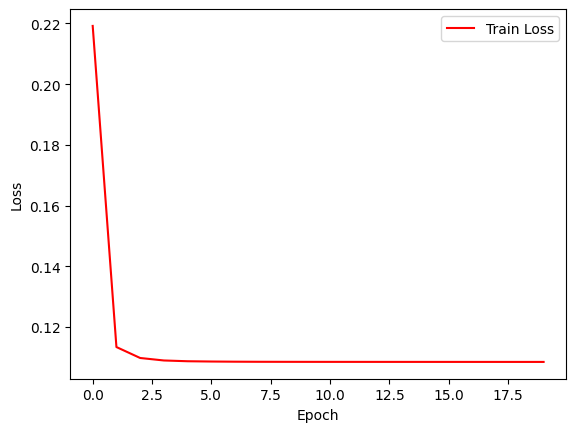

In [52]:
# Plot loss function for training and validation sets
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss'])

In [ ]:
# Look at the training data set
import pandas as pd
panda = pd.DataFrame(X_train_scaled.cpu().numpy(),columns=input_columns)